In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialisation

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from LogGabor import LogGabor
import torch
from torchvision import datasets, transforms
import os
import noise
import MotionClouds as mc

In [26]:
from Where import *

In [4]:
i_offset, j_offset = 15, 15

### MNIST_28

Loading accuracy... min, max= 0.0145 0.9852


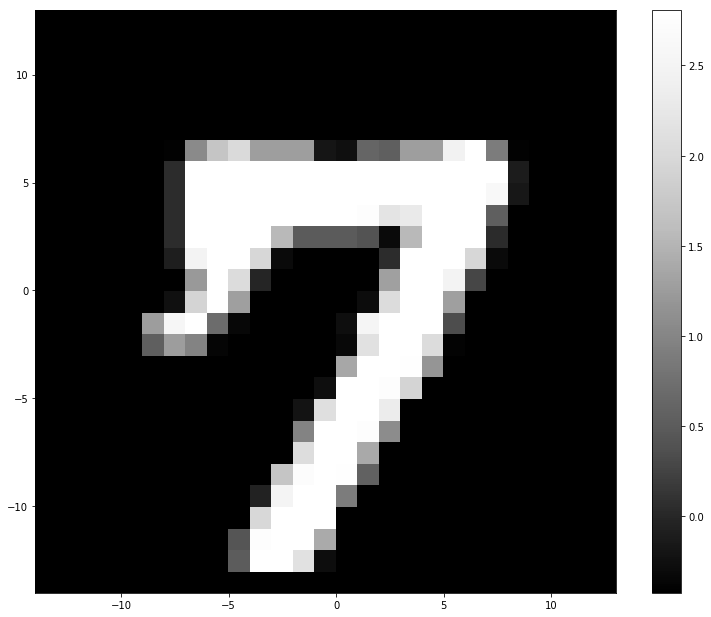

In [7]:
path = 'MNIST_28.pdf'
N_pic = 28
for batch_idx, (data, target) in enumerate(data_loader):
    data_28 = data[-1][-1]
    fig, ax = plt.subplots(figsize=(13, 10.725))
    cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), np.flipud(data_28), cmap='Greys_r')
    fig.colorbar(cmap)
    #plt.savefig(path)
    break

### MNIST_128

Loading accuracy... min, max= 0.0145 0.9852


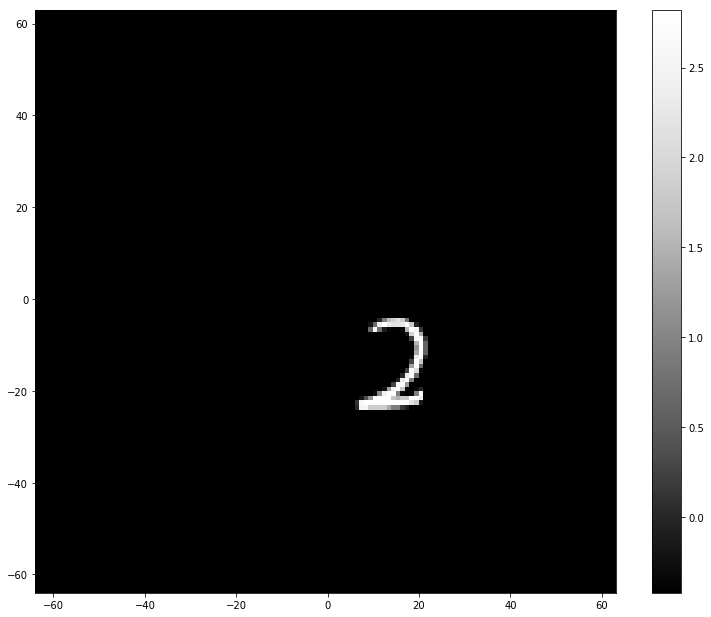

In [10]:
for batch_idx, (data,target) in enumerate(data_loader):
    mnist_fullfield(data[0, 0, :, :], i_offset, j_offset, figure_type='128')
    break

### Bruit perlin

NameError: name 'randomized_perlin_noise' is not defined

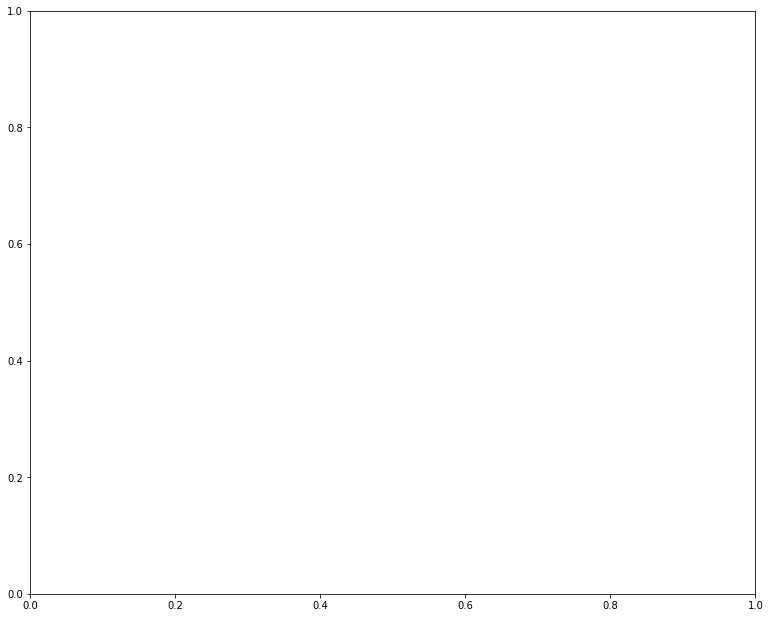

In [7]:
fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), randomized_perlin_noise())
fig.colorbar(cmap)

### Bruit MotionCloud

Loading accuracy... min, max= 0.0145 0.9852


(<Figure size 936x772.2 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb2bf6f6a90>)

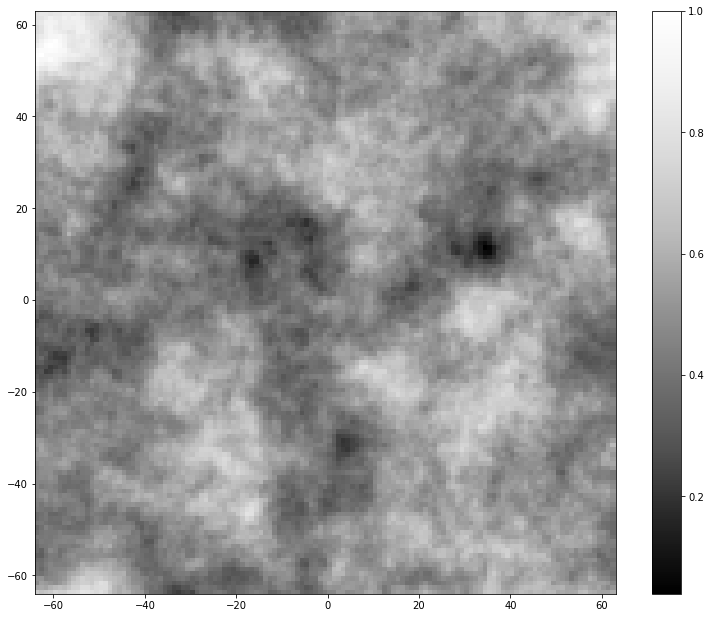

In [21]:
MotionCloudNoise(figure_type='cmap')

### Filtre LogPol classique

Loading accuracy... min, max= 0.0145 0.9852


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb2bd2fe278>)

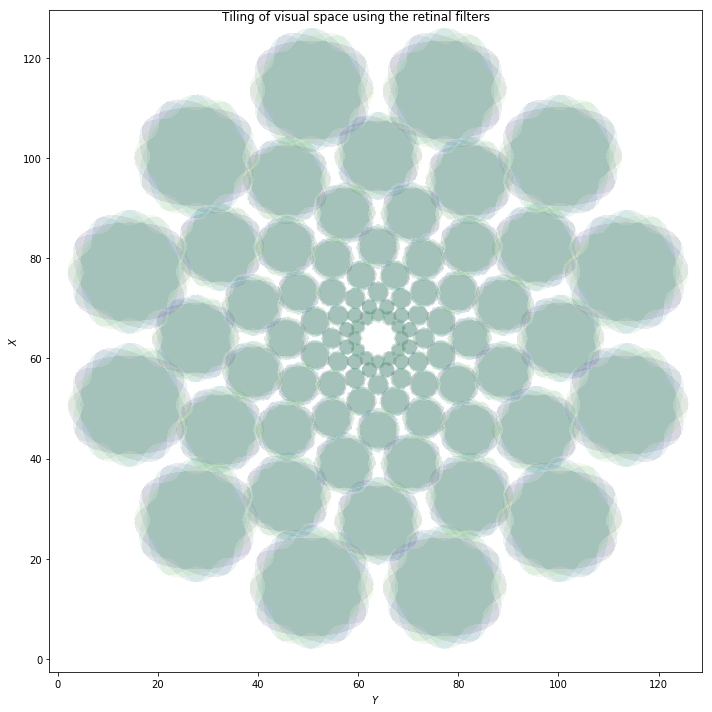

In [30]:
vectorization(figure_type='contourf')

In [20]:
rho

1.41

### Filtre LogPol classique + image

In [ ]:
mnist_fullfield(data_28, i_offset,j_offset, noise=False, figure_type='cmap')
plt.savefig('mnist_128_LP_nonoise.pdf')

### Filtre LogPol classique + image + bruit perlin

In [ ]:
mnist_128(i_offset,j_offset, noise=True, noise_type='Perlin')

### Filtre LogPol classique + image + bruit MotionCloud

In [ ]:
mnist_128(i_offset,j_offset, noise=True, noise_type='MotionCloud')
plt.savefig('mnist_128_LP_MotionCloud.pdf')

### Filtre LogPolaire + image + MotionCloud (méthode alternative de déplacement de MNIST au sein de l'image)

In [ ]:
mnist_128_meth2(i_offset, j_offset)

### Filtre LogPol + orientations moyennées

In [ ]:
energy = (phi**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_orient*N_scale, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_orient):
    for i_scale in range(N_scale):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()
plt.savefig('logpol_energy_filter.pdf')

### Filtre LogPol + orientations moyennées + accuracy

In [ ]:
path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy =  np.load(path)

accuracy_128(i_offset,j_offset)
plt.savefig('accuracy_128_LP.pdf')

### LogPolar view

In [ ]:
mnist_128(i_offset,j_offset, noise=False, figure_type='log')
plt.savefig('mnist_log_nonoise.pdf')

### LogPolar view + noise

In [ ]:
mnist_128(i_offset, j_offset, figure_type='log')
plt.savefig('mnist_log_motioncloud.pdf')